In [73]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
)
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
import pandas as pd 
import json



First we deal with the data

In [74]:

df = pd.read_html('./players_Big 5 European Leagues Combined_2324_standard.html')
df = df[0]
df.head()
df.reset_index(inplace=True)
df.columns = df.columns.droplevel(0)


In [75]:
new_columns = ['', 'Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born',
    'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
    'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
    'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90', 'xG/90', 'xAG/90',
    'xG+xAG/90', 'npxG/90', 'npxG+xAG/90', 'Matches']

df.columns = new_columns


convert values to numeric for easy computation and comparisons 

In [76]:
df['Age'] = df['Age'].str[:2]
df['Age'] =pd.to_numeric(df['Age'], errors='coerce')
df['90s'] =pd.to_numeric(df['90s'], errors='coerce')
columns_to_convert = ['MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
                      'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
                      'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90',
                      'xG/90', 'xAG/90', 'xG+xAG/90', 'npxG/90', 'npxG+xAG/90','Matches']

df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df.MP = pd.to_numeric(df.MP, errors='coerce')   

In [77]:
u_prompt = "top ten players with more than 5 goals"
players_with_more_than_5_goals = df[df['Gls'] > 5][['Player','Squad' ,'Comp','Gls', 'MP', 'Nation', 'Age', 'xG']] 
players_with_more_than_5_goals = players_with_more_than_5_goals.sort_values(by='Gls', ascending=False)
players_with_more_than_5_goals.head(10)


,Player,Squad,Comp,Gls,MP,Nation,Age,xG
1128,Harry Kane,Bayern Munich,de Bundesliga,21.0,15.0,eng ENG,30.0,15.1
1478,Kylian Mbappé,Paris S-G,fr Ligue 1,18.0,16.0,fr FRA,25.0,14.9
918,Serhou Guirassy,Stuttgart,de Bundesliga,17.0,14.0,gn GUI,27.0,11.6
1439,Lautaro Martínez,Inter,it Serie A,16.0,17.0,ar ARG,26.0,9.7
933,Erling Haaland,Manchester City,eng Premier League,14.0,15.0,no NOR,23.0,14.8
2037,Mohamed Salah,Liverpool,eng Premier League,14.0,20.0,eg EGY,31.0,14.3
222,Jude Bellingham,Real Madrid,es La Liga,13.0,17.0,eng ENG,20.0,7.2
1469,Borja Mayoral,Getafe,es La Liga,12.0,19.0,es ESP,26.0,8.7
989,Son Heung-min,Tottenham,eng Premier League,12.0,20.0,kr KOR,31.0,7.1
1581,Álvaro Morata,Atlético Madrid,es La Liga,12.0,18.0,es ESP,31.0,8.7


In [78]:
players_laliga = df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'MP', 'Nation', 'Age']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records')
players_laliga

'[{"Player":"Jude Bellingham","Squad":"Real Madrid","Comp":"es La Liga","Gls":13.0,"MP":17.0,"Nation":"eng ENG","Age":20.0}]'

In [79]:
u_prompt = "players with most xg in the epl "
players_eng_xg = df[df['Comp'] == 'eng Premier League'][['Player','Squad', 'Comp', 'xG', 'MP', 'Nation', 'Age']]
players_eng_xg = players_eng_xg.sort_values(by='xG', ascending=False)
players_eng_xg.head(10).to_json(orient='records')


'[{"Player":"Erling Haaland","Squad":"Manchester City","Comp":"eng Premier League","xG":14.8,"MP":15.0,"Nation":"no NOR","Age":23.0},{"Player":"Mohamed Salah","Squad":"Liverpool","Comp":"eng Premier League","xG":14.3,"MP":20.0,"Nation":"eg EGY","Age":31.0},{"Player":"Dominic Solanke","Squad":"Bournemouth","Comp":"eng Premier League","xG":11.0,"MP":19.0,"Nation":"eng ENG","Age":26.0},{"Player":"Nicolas Jackson","Squad":"Chelsea","Comp":"eng Premier League","xG":10.6,"MP":19.0,"Nation":"sn SEN","Age":22.0},{"Player":"Alexander Isak","Squad":"Newcastle Utd","Comp":"eng Premier League","xG":9.2,"MP":15.0,"Nation":"se SWE","Age":24.0},{"Player":"Ollie Watkins","Squad":"Aston Villa","Comp":"eng Premier League","xG":9.0,"MP":20.0,"Nation":"eng ENG","Age":28.0},{"Player":"Darwin N\\u00fa\\u00f1ez","Squad":"Liverpool","Comp":"eng Premier League","xG":8.6,"MP":19.0,"Nation":"uy URU","Age":24.0},{"Player":"Bryan Mbeumo","Squad":"Brentford","Comp":"eng Premier League","xG":8.5,"MP":15.0,"Nation":"

In [80]:
u_prompt = "top goal scorer in la liga"
players_laliga = df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'MP', 'Nation', 'Age']]
players_laliga = players_laliga.sort_values(by='Gls', ascending=False)
s = players_laliga.head(1)
s.to_json(orient='records')

'[{"Player":"Jude Bellingham","Squad":"Real Madrid","Comp":"es La Liga","Gls":13.0,"MP":17.0,"Nation":"eng ENG","Age":20.0}]'

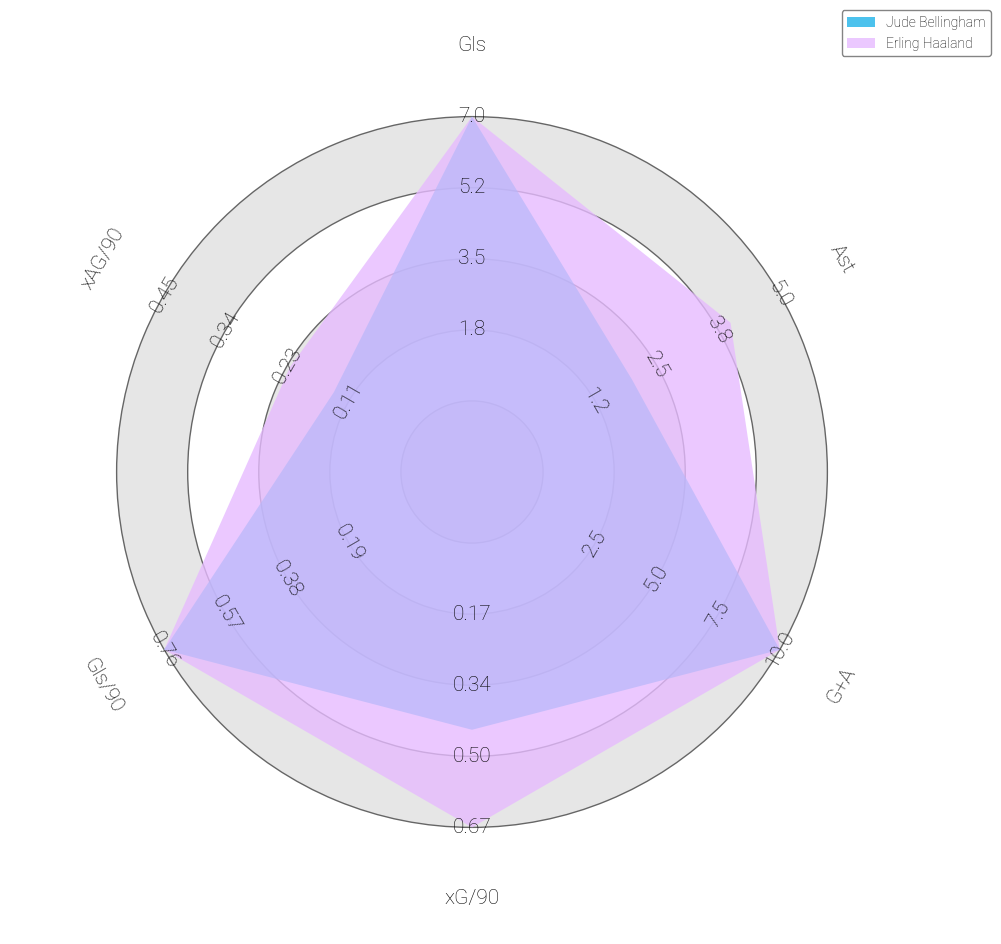

In [129]:

players_laliga = df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'Ast','G+A' , 'xG/90', 'Gls/90','xAG/90']]
players_laliga = players_laliga.sort_values(by='Gls', ascending=False)
player1= json.loads(players_laliga.head(1).to_json(orient='records'))
players_epl = df[df['Comp'] == 'eng Premier League'][['Player','Squad', 'Comp', 'Gls', 'Ast','G+A','xG/90', 'Gls/90','xAG/90']]
players_epl = players_epl.sort_values(by='Gls', ascending=False)
player2= json.loads(players_epl.head(1).to_json(orient='records'))
player1= player1[0]
player2= player2[0]
params = list(player1.keys())
params_chosen = params[3:]
player2_values = df[df.Player == player2['Player']][params_chosen].values.tolist()[0]
player1_values = df[df.Player == player1['Player']][params_chosen].values.tolist()[0]
player_values_tuple = (player1, player2)
plot_radar(player_values_tuple)


In [82]:
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

# parameter names of the statistics we want to show

URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

In [128]:
player1

{'Player': 'Lautaro Martínez',
 'Squad': 'Inter',
 'Comp': 'it Serie A',
 'Gls': 16.0,
 'Ast': 2.0,
 'G+A': 18.0,
 'xG/90': 0.61,
 'Gls/90': 1.01,
 'xAG/90': 0.1}

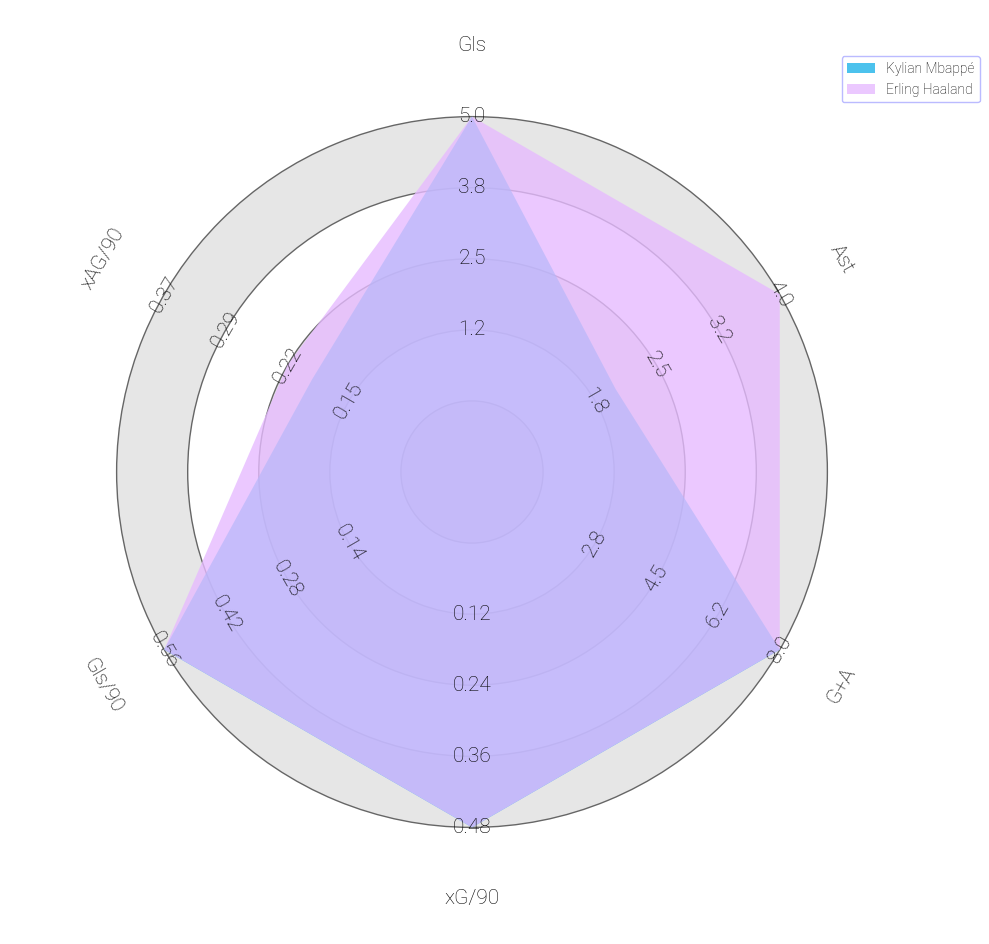

In [148]:

def plot_radar(player_values_tuple):
    player1, player2 = player_values_tuple
   
    # Extract parameters
    params_chosen = list(player1.keys())[3:]
    player2_values = df[df.Player == player2['Player']][params_chosen].values.tolist()[0]
    player1_values = df[df.Player == player1['Player']][params_chosen].values.tolist()[0]
    
    # Calculate low and high values
    #low = [df[i].quantile(0.05) for i in df[params_chosen]]
    #high = [df[i].quantile(1) for i in df[params_chosen]]
    
    low = [df[i].quantile(0.05) + df.loc[df['MP'] > 5, i].values[0] for i in params_chosen]
    high = [df[i].quantile(.95) + df.loc[df['MP'] > 5, i].values[0] for i in params_chosen]
    # Radar setup
    radar = Radar(params_chosen, low, high,
                  round_int=[False]*len(params_chosen),
                  num_rings=4, ring_width=1, center_circle_radius=1)
    
    # Plot radar
    fig, ax = radar.setup_axis()

    # Rings
    rings_inner = radar.draw_circles(ax=ax, facecolor='#e6e6e6', edgecolor='#666666')

    # Radar plot
    radar_output = radar.draw_radar_compare(player1_values, player2_values, ax=ax,
                                            kwargs_radar={'facecolor': '#00a8e6', 'alpha': 0.7},
                                            kwargs_compare={'facecolor': '#e6bbff', 'alpha': 0.8})
    radar_poly, radar_poly2, vertices1, vertices2 = radar_output

    # Labels
    range_labels = radar.draw_range_labels(ax=ax, fontsize=15, fontproperties=robotto_thin.prop)
    param_labels = radar.draw_param_labels(ax=ax, fontsize=15, fontproperties=robotto_thin.prop)

    # Legend
    legend = ax.legend([radar_poly, radar_poly2], [player1['Player'], player2['Player']],
                       loc=(0.9, .90), fontsize=25, frameon=True, prop=robotto_thin.prop)
    # legend.get_frame().set_facecolor('#e6e6e6')  # Light gray legend background
    legend.get_frame().set_edgecolor('#aaaaff66')  # Gray legend edge color

    plt.show()

# Example usage
player_values_tuple = (player1, player2)
plot_radar(player_values_tuple)


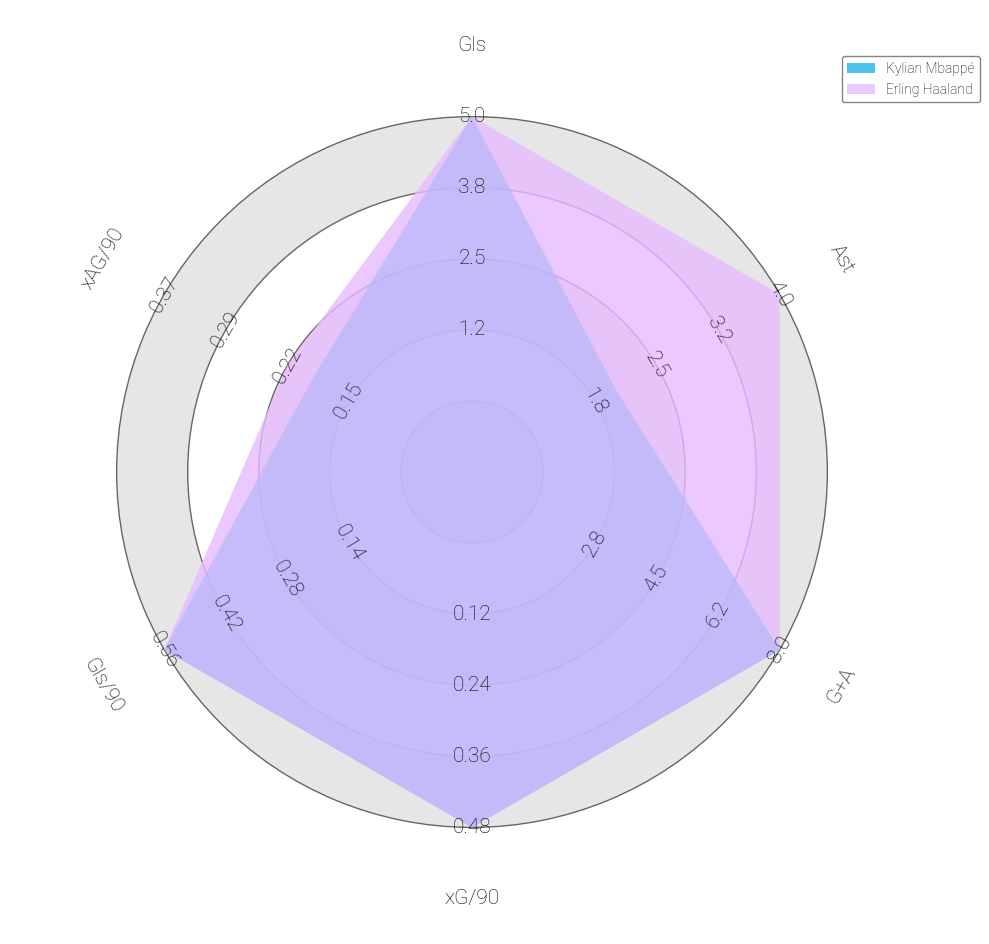

In [141]:
params = list(player1.keys())
params_chosen = params[3:]
player2_values = df[df.Player == player2['Player']][params_chosen].values.tolist()[0]
player1_values = df[df.Player == player1['Player']][params_chosen].values.tolist()[0]
player_values_tuple = (player1, player2)
plot_radar(player_values_tuple)

In [120]:
template = """
you help query a database and as such must always return python code that can be executed to get the answer to the question.
a list of column names which correspond to football facts are listed ['MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
       'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
       'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90', 'xG/90', 'xAG/90',
       'xG+xAG/90', 'npxG/90', 'npxG+xAG/90' ]  


       
       example
        questions: "top goal scorer in la liga"
        you :df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'MP', 'Nation', 'Age']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records')

        questions = "players with most xg in the epl "
        you:df[df['Comp'] == 'eng Premier League'][['Player','Squad', 'Comp', 'xG', 'MP', 'Nation', 'Age']].sort_values(by='xG', ascending=False).head(10).to_json(orient='records')

        questions = "compare the best player in la liga with the best player in the epl"
        you: params = list(df.columns[3:]) 
       get_player = lambda comp: json.loads(df[df['Comp'] == comp][['Player', 'Squad', 'Comp', 'Gls', 'Ast', 'G+A', 'xG/90', 'Gls/90', 'xAG/90']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records'))[0]
       player1, player2 = map(get_player, ['es La Liga', 'eng Premier League'])
       plot_radar((player1, player2))

         """
human_input = "{question}" 

In [102]:
chat_model = ChatOpenAI()

In [122]:
insider

"params = list(df.columns[3:]) \nget_player = lambda comp: json.loads(df[df['Comp'] == comp][['Player', 'Squad', 'Comp', 'Gls', 'Ast', 'G+A', 'xG/90', 'Gls/90', 'xAG/90']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records'))[0]\nplayer1, player2 = map(get_player, ['it Serie A', 'eng Premier League'])\nplot_radar((player1, player2))"

In [123]:
player1

{'Player': 'Lautaro Martínez',
 'Squad': 'Inter',
 'Comp': 'it Serie A',
 'Gls': 16.0,
 'Ast': 2.0,
 'G+A': 18.0,
 'xG/90': 0.61,
 'Gls/90': 1.01,
 'xAG/90': 0.1}

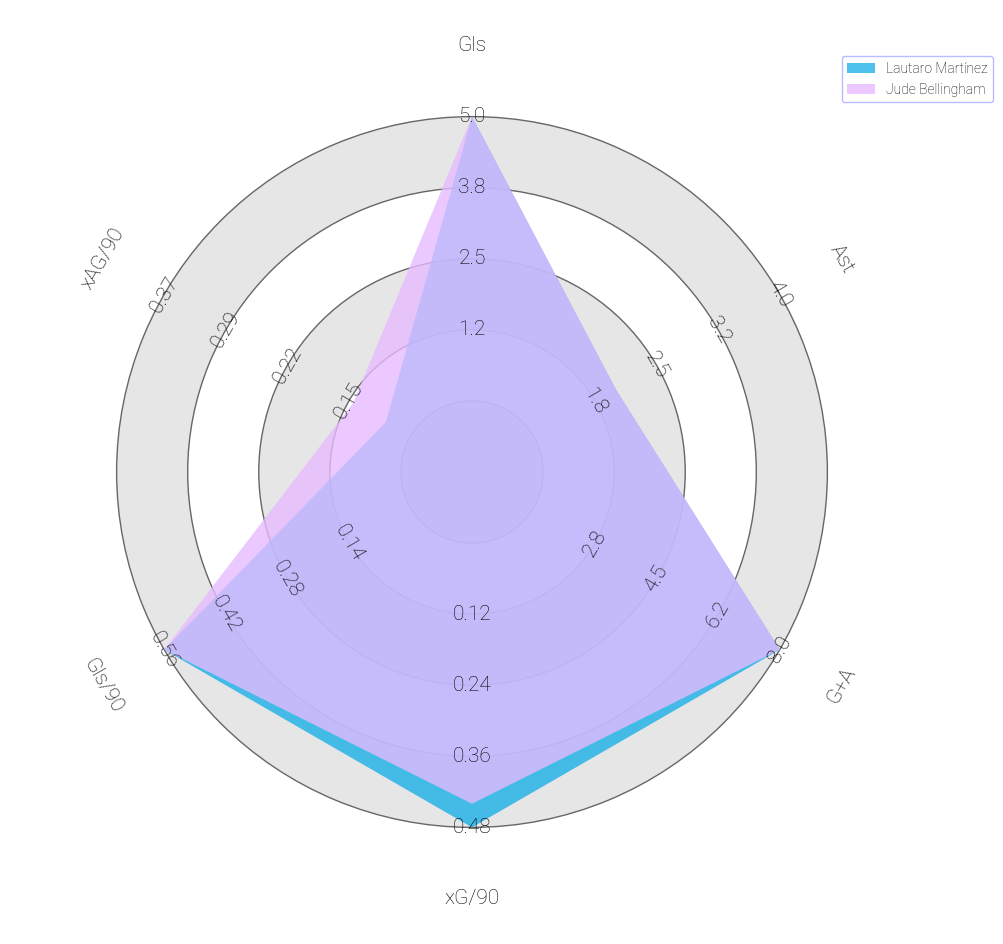

In [154]:
chat_prompt = ChatPromptTemplate.from_messages([("system", template), ("human", human_input)])
messages = chat_prompt.format_messages(question = "compare the best player in serie a with the best player in the spain")
result = chat_model.predict_messages(messages)
insider = result.content
exec(insider ,globals(), locals())


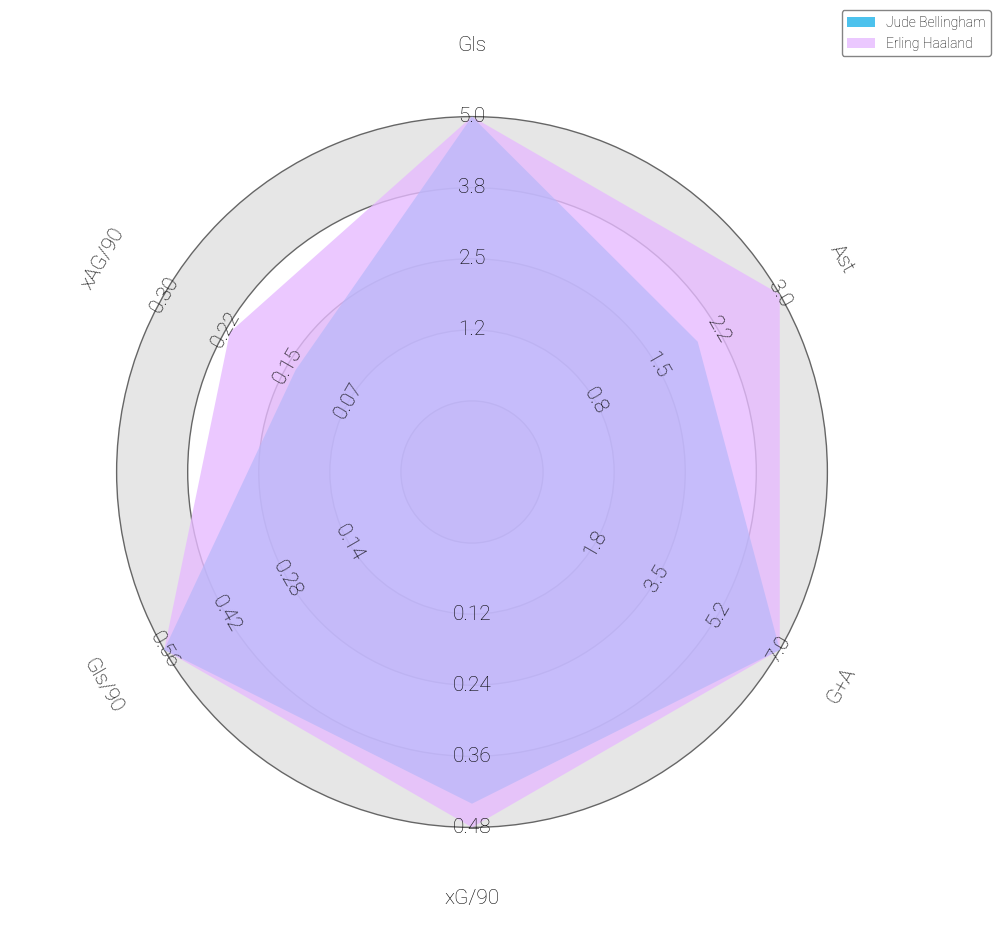

content="params = list(df.columns[3:])\nget_player = lambda comp: json.loads(df[df['Comp'] == comp][['Player', 'Squad', 'Comp', 'Gls', 'Ast', 'G+A', 'xG/90', 'Gls/90', 'xAG/90']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records'))[0]\nplayer1, player2 = map(get_player, ['es La Liga', 'eng Premier League'])\nplot_radar(player_values_tuple)"


In [104]:
chat_model = ChatOpenAI()

In [105]:
first_one = """Write some python code to query the database and  the user's question football
a list of column names which correspond to football facts are listed ['MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK',
       'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC',
       'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90', 'G+A-PK/90', 'xG/90', 'xAG/90',
       'xG+xAG/90', 'npxG/90', 'npxG+xAG/90' ]  


       
       example questions: "top goal scorer in la liga"
        you :a = df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'MP', 'Nation', 'Age']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records')

        questions = "players with most xg in the epl "
        you:a = df[df['Comp'] == 'eng Premier League'][['Player','Squad', 'Comp', 'xG', 'MP', 'Nation', 'Age']].sort_values(by='xG', ascending=False).head(10).to_json(orient='records')
 
        questions = "compare the top goal scorer in la liga and epl"
        you: a = df[df['Comp'] == 'es La Liga'][['Player', 'Squad','Comp', 'Gls', 'Ast','G+A' , 'xG/90', 'Gls/90','xAG/90']].sort_values(by='Gls', ascending=False).head(1).to_json(orient='records')

      

 """

LangChain. Shall we?   yes we shall.